In [1]:
import os
from src.predict import StegoDetector
from src.batch_analyze import batch_analyze_models
from src.retrain_model import retrain_with_consistent_features
from src.retrain_fixed_features import retrain_with_fixed_features
from src.predict_robust import RobustStegoDetector
from src.check_model_features import check_trained_model, check_current_feature_extraction
from src.config import config

model_path = os.path.join(config.MODEL_DIR, "trained", "best_stego_classifier.pkl")
if not os.path.exists(model_path):
    print(f"Model file not found: {model_path}")

    
detector = StegoDetector(model_path)

Using device: cpu
Test data prepared successfully
Loaded model: RandomForestClassifier


In [25]:
print("=== CHECKING TRAINED MODEL ===")
# check_trained_model(model="consistent_stego_classifier.pkl")
check_trained_model(model="consistent_stego_classifier_balancing.pkl")
# check_trained_model(model="fixed_features_classifier_.pkl")
# check_trained_model(model="best_stego_classifier_advenced.pkl")

# print("\n=== CHECKING CURRENT FEATURE EXTRACTION ===")
# current_features = check_current_feature_extraction()
    
# print(f"\nTotal features currently extracted: {len(current_features)}")

=== CHECKING TRAINED MODEL ===
✅ Model has feature names saved
Model type: GradientBoostingClassifier
Model expects 16 features
Saved feature names (16):
   1. weight_mean
   2. weight_std
   3. weight_skew
   4. weight_kurtosis
   5. reconstruction_loss
   6. grad_mean
   7. grad_std
   8. grad_max
   9. entropy_bit_0
  10. entropy_bit_1
  11. entropy_bit_2
  12. entropy_bit_3
  13. weight_median
  14. weight_near_zero
  15. bit_transition_mean
  16. spatial_corr_mean


Loaded features: (202, 37)
Using 16 consistent features: ['weight_mean', 'weight_std', 'weight_skew', 'weight_kurtosis', 'reconstruction_loss', 'grad_mean', 'grad_std', 'grad_max', 'entropy_bit_0', 'entropy_bit_1', 'entropy_bit_2', 'entropy_bit_3', 'weight_median', 'weight_near_zero', 'bit_transition_mean', 'spatial_corr_mean']

Training random_forest...

random_forest Performance:
Accuracy: 0.9016
Precision: 0.8750
Recall: 0.9333
F1_score: 0.9032


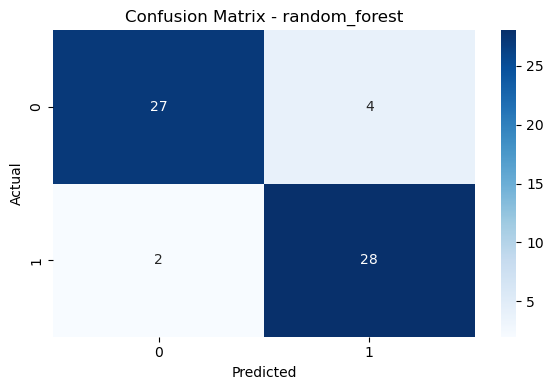


Training gradient_boosting...

gradient_boosting Performance:
Accuracy: 0.9508
Precision: 0.9355
Recall: 0.9667
F1_score: 0.9508


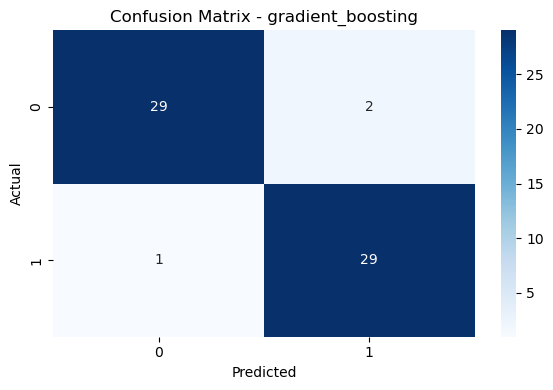


Training svm...

svm Performance:
Accuracy: 0.5082
Precision: 0.5000
Recall: 1.0000
F1_score: 0.6667


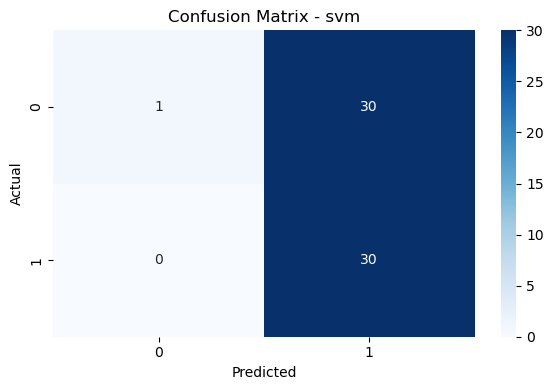


Best model: gradient_boosting
Model and feature names saved to c:\Users\oktan\Research\Steganalysis-for-LSB-Attack-Detection-in-Neural-Net-Models\steganalysis_ai_v2\models\trained\consistent_stego_classifier_balancing.pkl
Model trained and saved as: consistent_stego_classifier_balancing.pkl
Features used: 16


(GradientBoostingClassifier(random_state=42),
 ['weight_mean',
  'weight_std',
  'weight_skew',
  'weight_kurtosis',
  'reconstruction_loss',
  'grad_mean',
  'grad_std',
  'grad_max',
  'entropy_bit_0',
  'entropy_bit_1',
  'entropy_bit_2',
  'entropy_bit_3',
  'weight_median',
  'weight_near_zero',
  'bit_transition_mean',
  'spatial_corr_mean'],
 {'random_forest': {'accuracy': 0.9016393442622951,
   'precision': 0.875,
   'recall': 0.9333333333333333,
   'f1_score': 0.9032258064516129},
  'gradient_boosting': {'accuracy': 0.9508196721311475,
   'precision': 0.9354838709677419,
   'recall': 0.9666666666666667,
   'f1_score': 0.9508196721311475},
  'svm': {'accuracy': 0.5081967213114754,
   'precision': 0.5,
   'recall': 1.0,
   'f1_score': 0.6666666666666666}})

In [3]:
# retrain_with_consistent_features(datasets="all_features.csv", conf="normal")
retrain_with_consistent_features(datasets="all_features_with_balacing.csv", conf="balancing")

In [4]:
# Test with some models
test_models = {}
    
# Load cover models for testing
print("Loading test models...")
    
# Example: Load original cover models
from src.model_acquisition import ModelAcquisition
acquirer = ModelAcquisition()
original_models = acquirer.download_pretrained_models()
    
# Add cover models to test
for name, model in original_models.items():
    test_models[f"cover_{name}"] = model
    
# Load some stego models for testing
stego_dir = os.path.join(config.MODEL_DIR, "stego")
if os.path.exists(stego_dir):
    stego_files = [f for f in os.listdir(stego_dir) if f.endswith('.pth')]
    
    for stego_file in stego_files[:3]:  # Test first 3 stego models
        model_path = os.path.join(stego_dir, stego_file)
        try:
            if "resnet50" in stego_file:
                model = detector.load_model_from_path(model_path, "resnet50")
                test_models[f"stego_{stego_file}"] = model
            elif "mobilenet" in stego_file:
                model = detector.load_model_from_path(model_path, "mobilenet_v3_small")
                test_models[f"stego_{stego_file}"] = model
        except Exception as e:
            print(f"Failed to load {stego_file}: {e}")

# Make predictions
print(f"\nAnalyzing {len(test_models)} models...")
results = detector.predict_multiple_models(test_models)

# Display results
print("\n" + "="*80)
print("PREDICTION RESULTS")
print("="*80)
    
for _, row in results.iterrows():
    status = "✅" if row['prediction'] in ['CLEAN', 'STEGO'] else "❌"
    print(f"{status} {row['model_name']:50} -> {row['prediction']:8} "
        f"(Stego: {row['stego_probability']:.3f}, "
        f"Confidence: {row['confidence']:.3f})")

# Summary statistics
clean_count = len(results[results['prediction'] == 'CLEAN'])
stego_count = len(results[results['prediction'] == 'STEGO'])
error_count = len(results[results['prediction'] == 'ERROR'])
    
print(f"\nSUMMARY:")
print(f"Clean models: {clean_count}")
print(f"Stego models: {stego_count}")
print(f"Errors: {error_count}")

Loading test models...
Failed to load mobilenet_v3_small_rate_0.001_bit_0.pth: 'StegoDetector' object has no attribute 'load_model_from_path'
Failed to load mobilenet_v3_small_rate_0.001_bit_1.pth: 'StegoDetector' object has no attribute 'load_model_from_path'
Failed to load mobilenet_v3_small_rate_0.001_bit_10.pth: 'StegoDetector' object has no attribute 'load_model_from_path'

Analyzing 2 models...
Analyzing: cover_resnet50
Extracting features for cover_resnet50...
  Extracted 2000 weight samples
Autoencoder trained successfully
  Reconstruction loss: 0.016070
  Gradient features: {'grad_mean': 1.5324169281661881, 'grad_std': 2.082658107710825, 'grad_max': 8.673813819885254}
  Entropy features calculated for 4 bit-planes


c:\Users\oktan\anaconda3\envs\thesis-py310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Error predicting model cover_resnet50: X has 34 features, but RandomForestClassifier is expecting 16 features as input.
  Result: ERROR (Confidence: 0.000, Stego Prob: 0.000)
Analyzing: cover_mobilenet_v3_small
Extracting features for cover_mobilenet_v3_small...
  Extracted 2000 weight samples
  Reconstruction loss: 0.245634
  Gradient features: {'grad_mean': 7.238178760967624, 'grad_std': 7.520347842934929, 'grad_max': 68.39440155029297}
  Entropy features calculated for 4 bit-planes
Error predicting model cover_mobilenet_v3_small: X has 34 features, but RandomForestClassifier is expecting 16 features as input.
  Result: ERROR (Confidence: 0.000, Stego Prob: 0.000)

PREDICTION RESULTS
❌ cover_resnet50                                     -> ERROR    (Stego: 0.000, Confidence: 0.000)
❌ cover_mobilenet_v3_small                           -> ERROR    (Stego: 0.000, Confidence: 0.000)

SUMMARY:
Clean models: 0
Stego models: 0
Errors: 2


c:\Users\oktan\anaconda3\envs\thesis-py310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [20]:
dir_path = os.path.join(config.MODEL_DIR, "cover")
batch_detector = batch_analyze_models(dir_path, "consistent_stego_classifier_balancing.pkl")
# batch_detector = batch_analyze_models(dir_path, "fixed_features_classifier_advenced.pkl")
# batch_detector = batch_analyze_models(dir_path, "best_stego_classifier.pkl")

Test data prepared successfully
Loaded model: dict
Found 2 model files to analyze...


Analyzing models:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting features for mobilenet_v3_small.pth...
  Extracted 2000 weight samples
Autoencoder trained successfully
  Reconstruction loss: 0.108560
  Gradient features: {'grad_mean': 12.966123721968959, 'grad_std': 20.539724413135488, 'grad_max': 171.3716278076172}
  Entropy features calculated for 4 bit-planes


c:\Users\oktan\anaconda3\envs\thesis-py310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
Analyzing models:  50%|█████     | 1/2 [00:01<00:01,  1.62s/it]

Error predicting model mobilenet_v3_small.pth: X has 34 features, but GradientBoostingClassifier is expecting 16 features as input.
Extracting features for resnet50.pth...
  Extracted 2000 weight samples
  Reconstruction loss: 0.031121
  Gradient features: {'grad_mean': 1.5484592581387633, 'grad_std': 2.156196259603046, 'grad_max': 9.508172035217285}
  Entropy features calculated for 4 bit-planes


c:\Users\oktan\anaconda3\envs\thesis-py310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
Analyzing models: 100%|██████████| 2/2 [00:10<00:00,  5.29s/it]

Error predicting model resnet50.pth: X has 34 features, but GradientBoostingClassifier is expecting 16 features as input.

Analysis complete! Results saved to: c:\Users\oktan\Research\Steganalysis-for-LSB-Attack-Detection-in-Neural-Net-Models\steganalysis_ai_v2\data\batch_analysis_results.csv

BATCH ANALYSIS SUMMARY:
Total models analyzed: 2
Clean models: 0
Stego models: 0
Errors: 2


In [17]:
# retrain_with_fixed_features("all_features_with_balacing.csv")
retrain_with_fixed_features("all_features.csv", "")

📁 Loaded features: (102, 15)
📊 Using 12 fixed features
Features: ['weight_mean', 'weight_std', 'weight_skew', 'weight_kurtosis', 'reconstruction_loss', 'grad_mean', 'grad_std', 'grad_max', 'entropy_bit_0', 'entropy_bit_1', 'entropy_bit_2', 'entropy_bit_3']
🎯 Final dataset: (102, 12)
📈 Class distribution: {1: 100, 0: 2}
🤖 Training Random Forest...

=== MODEL PERFORMANCE ===
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

💾 Model saved to: c:\Users\oktan\Research\Steganalysis-for-LSB-Attack-Detection-in-Neural-Net-Models\steganalysis_ai_v2\models\trained\fixed_features_classifier_.pkl
📊 Features: 12
🔧 Feature set: standard_12_features


(RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42),
 ['weight_mean',
  'weight_std',
  'weight_skew',
  'weight_kurtosis',
  'reconstruction_loss',
  'grad_mean',
  'grad_std',
  'grad_max',
  'entropy_bit_0',
  'entropy_bit_1',
  'entropy_bit_2',
  'entropy_bit_3'])

In [4]:
model_pathX = os.path.join(config.MODEL_DIR, "trained", "fixed_features_classifier_advenced.pkl")
detectorRobust = RobustStegoDetector(model_pathX)

📊 Model expects 12 features
Test data prepared successfully
🤖 Classifier: RandomForestClassifier
📊 Expected features: 12
